In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq

## 1. Denver monthly listing,  sells and mean house price

In [2]:
market_area = 'denver'
data_dir = 'index-team-data'
data_path = f'../../{data_dir}/{market_area}'

In [3]:
#read the denver listing dates
listData = pd.read_csv(f'{data_path}/listing_dates_cleaned.csv')
listData['sale_month'] = listData.sale_date.apply(lambda x: str(x)[:-3])
listData['list_month'] = listData.list_date.apply(lambda x: str(x)[:-3])
#listData['sale_date'] = pd.to_datetime(listData['sale_date'],format='%Y-%m-%d')
#listData['list_date'] = pd.to_datetime(listData['list_date'],format='%Y-%m-%d')
listMonth = listData.groupby(['list_month']).agg({"property_id":"count"}).reset_index().iloc[:-1,:]
saleMonth = listData.groupby(['sale_month']).agg({"property_id":"count", "sale_price":"mean"}).reset_index().iloc[1:-2,:]

In [3]:
monthData = pd.merge(saleMonth,listMonth, left_on='sale_month',right_on='list_month')
monthData = monthData.rename(columns={"sale_month":"month","property_id_x":"count_sale", "property_id_y":"count_list","sale_price":"mean_price"})
monthData = monthData.drop(['list_month'],axis=1)
monthData#month from 2016-03 to 2020-09, 55 months in total

,month,count_sale,mean_price,count_list
0,2016-03,5259,392825.600494,12926
1,2016-04,5571,403625.623586,10692
2,2016-05,6340,415779.824132,9405
3,2016-06,6941,427446.501945,9635
4,2016-07,6476,418647.276714,8318
5,2016-08,6686,410690.159438,7864
6,2016-09,6218,402149.781923,7148
7,2016-10,5719,402886.176779,5559
8,2016-11,5421,407862.914960,4179
9,2016-12,5317,404484.769607,2939


Text(0.5, 1.0, 'Trends in sell house counts each month in Denver')

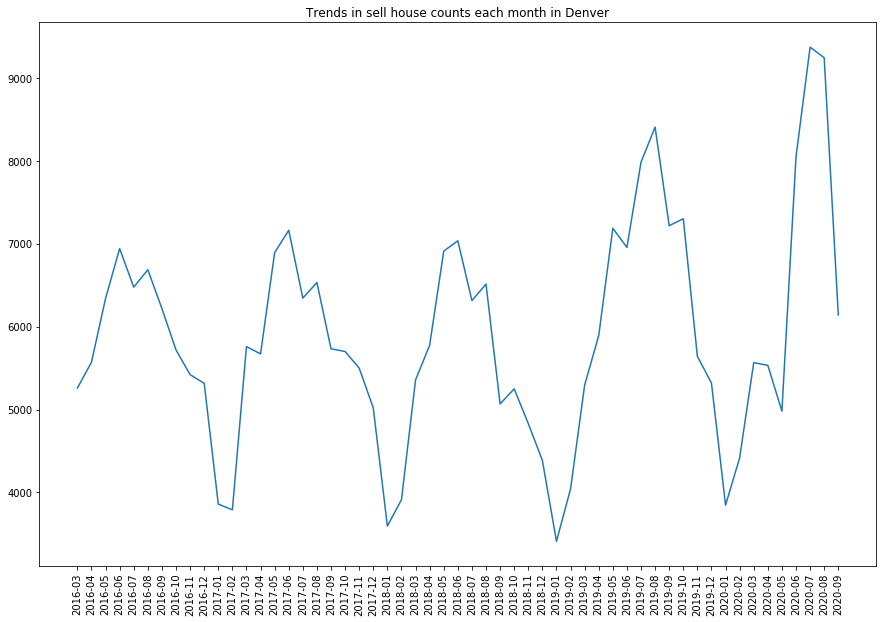

In [4]:
plt.figure(figsize=(15, 10))
plt.plot(monthData['month'],monthData['count_sale'])
plt.xticks(rotation=90)
plt.title('Trends in sell house counts each month in Denver')

Text(0.5, 1.0, 'Trends in house price each month in Denver')

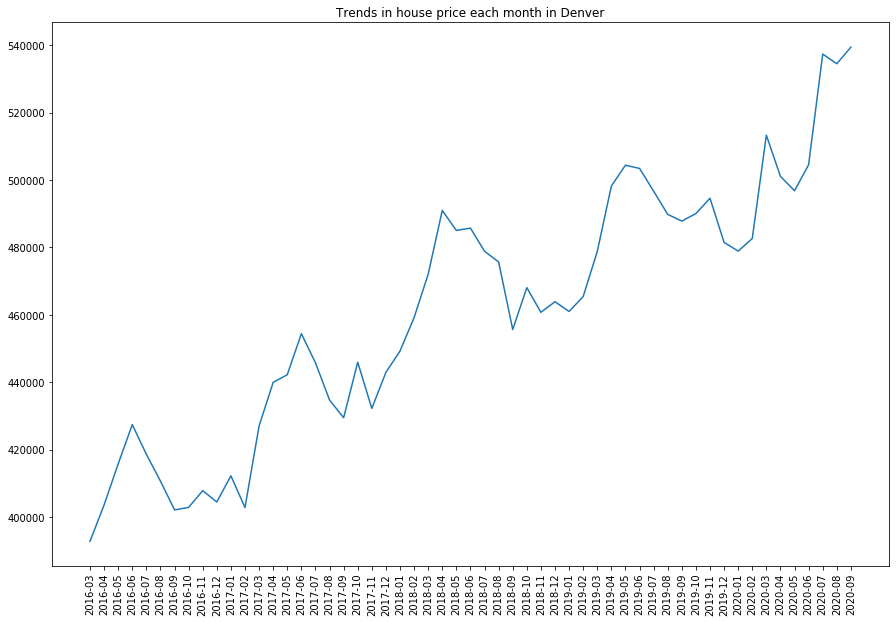

In [5]:
plt.figure(figsize=(15, 10))
plt.plot(monthData['month'],monthData['mean_price'])
plt.xticks(rotation=90)
plt.title('Trends in house price each month in Denver')

Text(0.5, 1.0, 'Trends in house newlist count each month in Denver')

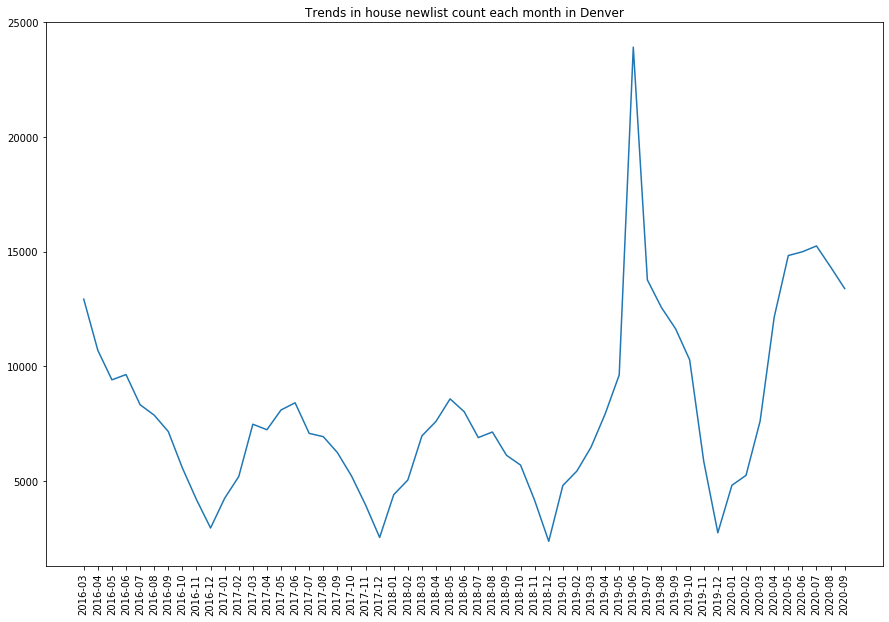

In [6]:
plt.figure(figsize=(15, 10))
plt.plot(monthData['month'],monthData['count_list'])
plt.xticks(rotation=90)
plt.title('Trends in house newlist count each month in Denver')

The plots show that the monthly house selling number, the mean trade price, and the new listed house number in Denver have a strong periodicity. These are three targets we want to predict using google trends data in today's model.

## 2. Google trends data

### 2.1 General used search terms from house buyers and sellers 

The house related search terms are acquired from Rex company. The buyer and seller datasets give us terms that house buyers and sellers would likely to search in google, along with their impressions, which means how many ads are exposed to people who searched the term, and also the interactions, the conversion rates. Since there are too many terms at head, we just use those with most impressions. It is assumed that terms bringing large exposure to ads have a larger effect on the house market. For buyers' terms, we use the first 20 keywords that counts for over 89% percent of total impressions. For sellers' terms, we use the first 30 keywords that counts for over 70% percent of total impressions.

Further, we exclude the keywords including obvious locations not in Denver, and delete phrases with same words(that is because word sequence does not impact the google trends outcome).

Last, when we get search terms, we acquire the monthly google trends data in Colorado from api. All trends for each term are normalized from 0 to 100 scale.

This idea is inspired by the paper, Wu, Lynn and Brynjolfsson, Erik, The Future of Prediction: How Google Searches Foreshadow Housing Prices and Sales (August 30, 2013){https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2022293}. Google trends data is useful in house market prediction for two aspects. For one thing, the sellers term predict the newly listed houses number. For another, both the sellers term and buyers term predict the house price and sales number. The paper predicts wide house index, like the house price index(HPI), however, we will focus on a more specific district here.

In [8]:
# set up google trends api
pytrends = TrendReq(hl='en-US', tz=300)
grouper = pd.Grouper(level='date', freq='M')

In [45]:
def get_keyword_to_time_series(keywords,geo='US-CO'):
    keyword_to_time_series = {}
    for keyword in keywords:
        print(keyword)
        pytrends.build_payload([keyword], cat=0, timeframe='2016-03-01 2020-09-30', geo=geo)
        pytrends_df = pytrends.interest_over_time()
        if len(pytrends_df)!=0: 
            pytrends_monthly_df = pytrends_df.groupby(grouper)[keyword].mean().reset_index()
            time_series = np.array(pytrends_monthly_df[keyword])
            keyword_to_time_series[keyword] = time_series
    return keyword_to_time_series

In [10]:
#load buyer search terms and seller search terms
buyer_df = pd.read_csv('data/buyer_keyword_report.csv')
seller_df = pd.read_csv('data/seller_keyword_report.csv')
def convert_to_int(s):
    return int(''.join(x for x in s if x.isdigit()))
buyer_df['Impr.'] = buyer_df['Impr.'].apply(convert_to_int)
seller_df['Impr.'] = seller_df['Impr.'].apply(convert_to_int)

In [12]:
display(buyer_df.head())
display(seller_df.head())

,Keyword,Match type,Impr.,Interactions,Interaction rate,Conv. rate
0,[buy 4 Bedroom Home In Windermere Fl],Exact match,0,0,--,0.00%
1,[buy 2 Bedroom Single House In Volusia County],Exact match,0,0,--,0.00%
2,[4 Bedroom Condo In Chicago for sale],Exact match,0,0,--,0.00%
3,[3 Bedroom Home In Canyon Country Ca for sale],Exact match,0,0,--,0.00%
4,[buy 1 Bedroom House In Pagosa Springs Co],Exact match,0,0,--,0.00%


,Keyword,Match type,Impr.,Interactions,Interaction rate,Conv. rate
0,"""what is the value of my home""",Phrase match,3212,476,14.82%,16.81%
1,+online +home +appraisal,Broad match,289,40,13.84%,8.75%
2,+trelora +agent,Broad match,0,0,--,0.00%
3,+market +value +of +my +house,Broad match,493,59,11.97%,10.17%
4,+how +much +would +my +house +be +worth,Broad match,158,23,14.56%,4.35%


In [238]:
buyer_word_sorted = buyer_df.groupby('Keyword')['Impr.'].max().sort_values(ascending=False)
seller_word_sorted = seller_df.groupby('Keyword')['Impr.'].max().sort_values(ascending=False)
#use max method because exact match and phrase match are included in the broad match

In [239]:
print(buyer_word_sorted.values.cumsum()[:20]/sum(buyer_word_sorted.values))
print(seller_word_sorted.values.cumsum()[:50]/sum(seller_word_sorted.values))

[0.38763931 0.5282684  0.64087642 0.7515058  0.77199057 0.79183519
 0.81045771 0.82168941 0.83111706 0.83978817 0.84828469 0.8545116
 0.86065121 0.86638345 0.87176652 0.87714959 0.88186342 0.88651904
 0.89105828 0.89542293]
[0.05739425 0.11008985 0.15021025 0.18990691 0.22285589 0.25429514
 0.28122773 0.30752869 0.33334814 0.35519595 0.37585248 0.39493141
 0.41309073 0.42926774 0.44538579 0.46143829 0.47625664 0.49038869
 0.50368103 0.51657775 0.5279475  0.53886753 0.54974723 0.56035077
 0.57083718 0.58111686 0.59021883 0.59894166 0.60747503 0.61599968
 0.6243461  0.63199827 0.63923524 0.64645339 0.65338861 0.66021853
 0.66692414 0.67325624 0.67927768 0.68477822 0.69024638 0.69564066
 0.70098897 0.70619591 0.71129464 0.71624152 0.7210769  0.72579883
 0.73045308 0.73492581]


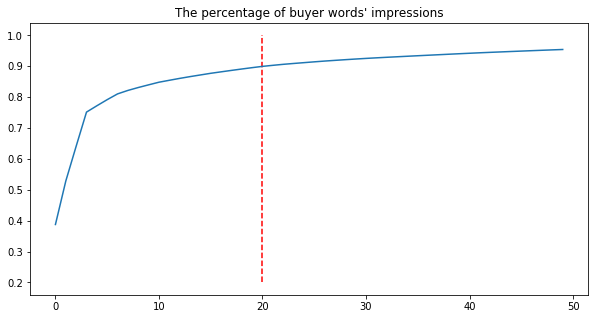

In [240]:
plt.figure(figsize=(10, 5))
plt.plot(buyer_word_sorted.values.cumsum()[:50]/sum(buyer_word_sorted.values))
plt.title("The percentage of buyer words' impressions")
plt.vlines(x=20,ymin=0.2, ymax=1,color='red',linestyles='dashed')
#Use the first 10 search words that counts for over 89% percent of total impressions

Text(0.5, 1.0, 'First 20 Impression buyer keywords')

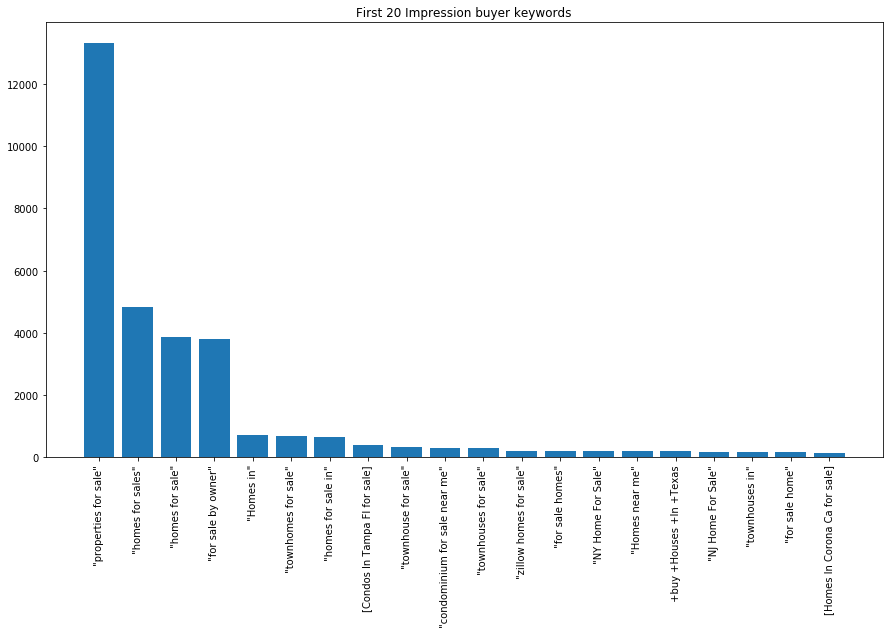

In [242]:
plt.figure(figsize=(15, 8))
num = 20
plt.bar(height =buyer_word_sorted.iloc[:num].values, x= buyer_word_sorted.iloc[:num].index)
plt.xticks(rotation=90)
plt.title('First {} Impression buyer keywords'.format(num))


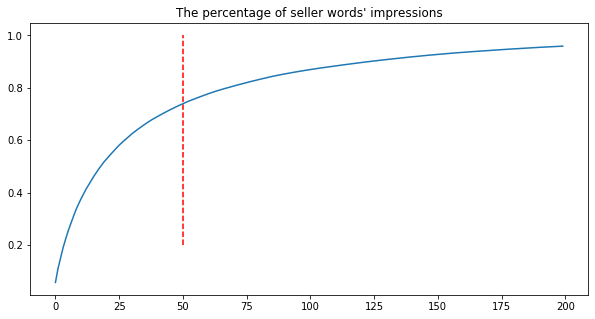

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(seller_word_sorted.values.cumsum()[:200]/sum(seller_word_sorted.values))
plt.title("The percentage of seller words' impressions")
plt.vlines(x=50,ymin=0.2, ymax=1,color='red',linestyles='dashed')
#For convenience, use the first 30 search words that counts for over 70% percent of total impressions

Text(0.5, 1.0, 'First 50 Impression seller keywords')

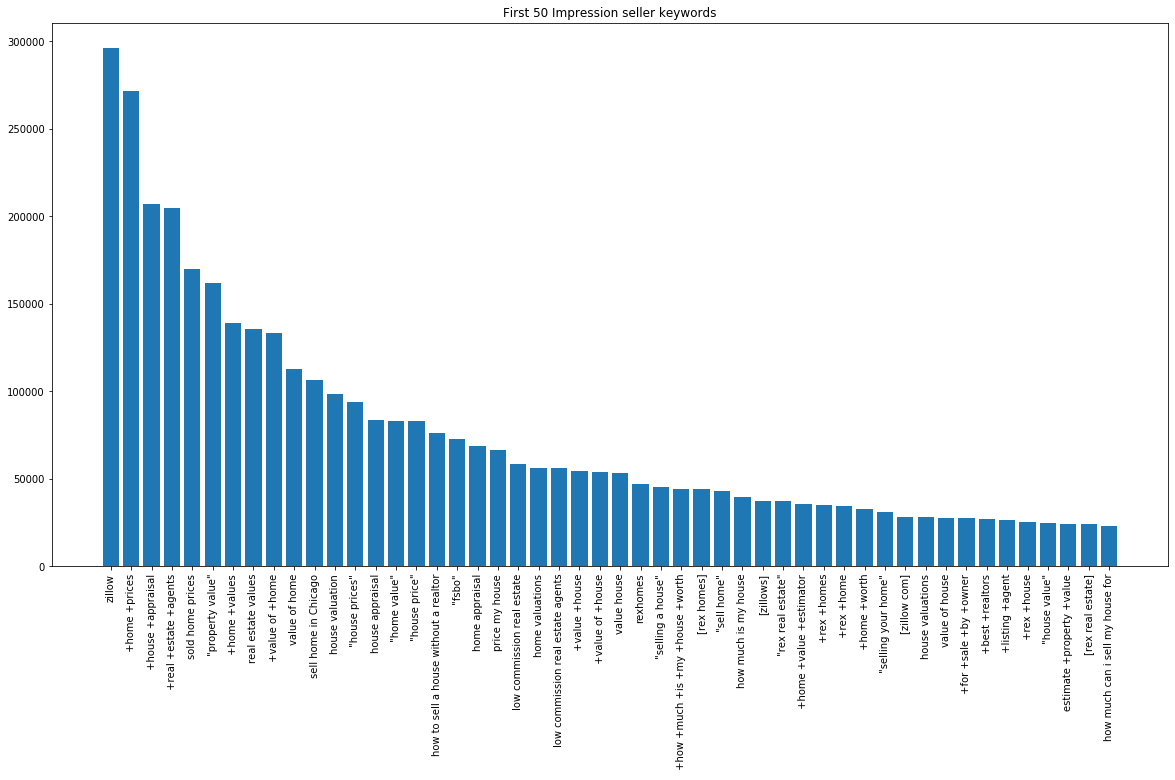

In [13]:
plt.figure(figsize=(20, 10))
num = 50
plt.bar(height =seller_word_sorted.iloc[:num].values, x= seller_word_sorted.iloc[:num].index)
plt.xticks(rotation=90)
plt.title('First {} Impression seller keywords'.format(num))

In [14]:
print(buyer_word_sorted.iloc[:20].index)
print(seller_word_sorted.iloc[:50].index)

Index(['"properties for sale"', '"homes for sales"', '"homes for sale"',
       '"for sale by owner"', '"Homes in"', '"townhomes for sale"',
       '"homes for sale in"', '[Condos In Tampa Fl for sale]',
       '"townhouse for sale"', '"condominium for sale near me"',
       '"townhouses for sale"', '"zillow homes for sale"', '"for sale homes"',
       '"NY Home For Sale"', '"Homes near me"', ' +buy +Houses +In +Texas',
       '"NJ Home For Sale"', '"townhouses in"', '"for sale home"',
       '[Homes In Corona Ca for sale]'],
      dtype='object', name='Keyword')
Index(['zillow', ' +home +prices', ' +house +appraisal',
       ' +real +estate +agents', 'sold home prices', '"property value"',
       ' +home +values', 'real estate values', ' +value of +home',
       'value of home', 'sell home in Chicago', 'house valuation',
       '"house prices"', 'house appraisal', '"home value"', '"house price"',
       'how to sell a house without a realtor', '"fsbo"', 'home appraisal',
       'price

In [15]:
# clean the keywords and delete duplicates
clean_keywords = lambda s: s.strip('""').strip('[]').strip(' ').replace('+','')
buyer_keywords = [clean_keywords(x) for x in buyer_word_sorted.iloc[:20].index]
seller_keywords = [clean_keywords(x) for x in seller_word_sorted.iloc[:50].index]
print(set(buyer_keywords))
print()
print(set(seller_keywords))

{'homes for sale', 'Homes in', 'townhomes for sale', 'townhouses in', 'homes for sale in', 'Homes near me', 'NY Home For Sale', 'buy Houses In Texas', 'properties for sale', 'townhouses for sale', 'for sale homes', 'condominium for sale near me', 'townhouse for sale', 'Condos In Tampa Fl for sale', 'for sale by owner', 'NJ Home For Sale', 'for sale home', 'zillow homes for sale', 'Homes In Corona Ca for sale', 'homes for sales'}

{'real estate agents', 'home valuations', 'rex home', 'sell home in Chicago', 'how much is my house', 'how much can i sell my house for', 'home prices', 'how much is my house worth', 'value of home', 'house valuation', 'house price', 'low commission real estate', 'rexhomes', 'how to sell a house without a realtor', 'house valuations', 'best realtors', 'home value', 'rex homes', 'sell home', 'selling your home', 'house prices', 'estimate property value', 'value house', 'sold home prices', 'house appraisal', 'home appraisal', 'value of house', 'selling a house',

In [31]:
#exclude those with obvious locations not in Denver, delete phrases with same words(because word sequence does not impact the google trends)
buyer_keywords = ['homes for sale', 'homes for sale in', 'properties for sale','for sale home','homes for sales', #home for sale
                  'townhomes for sale','townhouses for sale','townhouse for sale', #townhome for sale
                  'Homes in', 
                  'townhouses in',  
                  'Homes near me', 
                  'condominium for sale near me', 
                  'for sale by owner',
                  'zillow homes for sale']

seller_keywords = ['selling a house','sell home', 'selling your home',
                 
                 'house appraisal', 'home values', 'home value estimator', 'home valuations','house value', 'house valuation', 'real estate values', 
                 'value of house','how much is my house','property value','house valuations', 'home worth', 
                 'how much can i sell my house for', 'estimate property value','value of home','home value', 'home prices', 
                 'low commission real estate', 'home appraisal', 'price my house','how much is my house worth', 
                 'sold home prices', 'house prices','house price', 
                 
                 'rexhomes', 'rex real estate', 'rex home', 'zillow', 'zillow com','zillows','real estate agents', 'rex homes'
                 'listing agent', 'best realtors','low commission real estate agents', 'rex house', 
                 'how to sell a house without a realtor',
                 
                 'for sale by owner', 'fsbo', 
                  
                 ]

In [32]:
%time buyer_keyword_to_time_series = get_keyword_to_time_series(buyer_keywords)

homes for sale
homes for sale in
properties for sale
for sale home
homes for sales
townhomes for sale
townhouses for sale
townhouse for sale
Homes in
townhouses in
Homes near me
condominium for sale near me
for sale by owner
zillow homes for sale
CPU times: user 2.02 s, sys: 46 ms, total: 2.07 s
Wall time: 20.8 s


In [34]:
%time seller_keyword_to_time_series = get_keyword_to_time_series(seller_keywords)

selling a house
sell home
selling your home
house appraisal
home values
home value estimator
home valuations
house value
house valuation
real estate values
value of house
how much is my house
property value
house valuations
home worth
how much can i sell my house for
estimate property value
value of home
home value
home prices
low commission real estate
home appraisal
price my house
how much is my house worth
sold home prices
house prices
house price
rexhomes
rex real estate
rex home
zillow
zillow com
zillows
real estate agents
rex homeslisting agent
best realtors
low commission real estate agents
rex house
how to sell a house without a realtor
for sale by owner
fsbo
CPU times: user 5.1 s, sys: 141 ms, total: 5.24 s
Wall time: 59.8 s


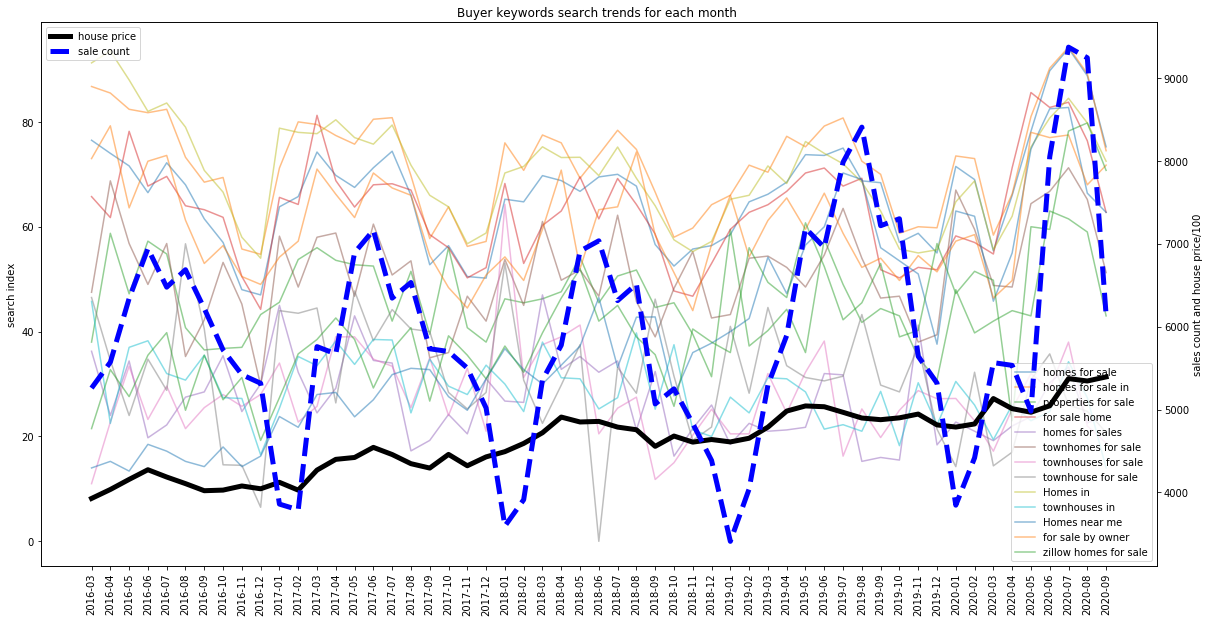

In [35]:
fig, ax1 = plt.subplots(figsize=(20,10))
for keyword, time_series in buyer_keyword_to_time_series.items():
    time_series = pd.Series(time_series, index=monthData.month.values)
    ax1.plot(time_series, label=keyword,alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(monthData['month'],monthData['mean_price']/100,label='house price', color='black', linewidth=5)
ax2.plot(monthData['month'],monthData['count_sale'],'--',label='sale count',color='blue', linewidth=5)
ax2.set_ylabel('sales count and house price/100')
ax1.set_ylabel('search index')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

ax2.legend()
ax1.legend()
plt.title('Buyer keywords search trends for each month ')
plt.show()

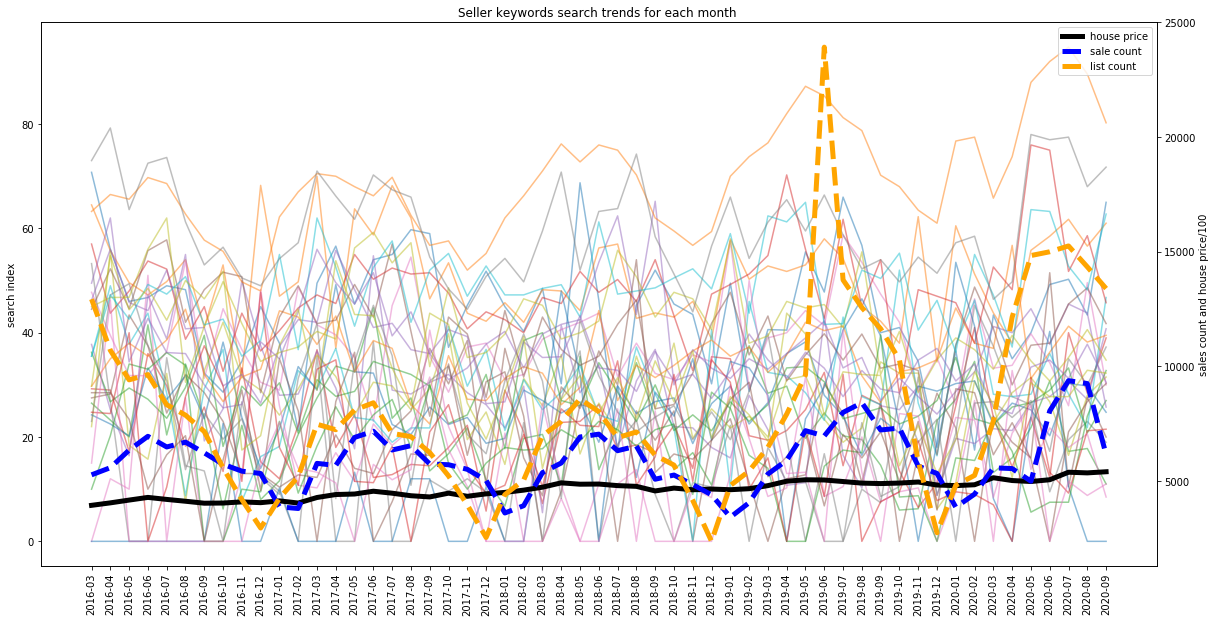

In [36]:
fig, ax1 = plt.subplots(figsize=(20,10))
for keyword, time_series in seller_keyword_to_time_series.items():
    time_series = pd.Series(time_series, index=monthData.month.values)
    ax1.plot(time_series, label=keyword,alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(monthData['month'],monthData['mean_price']/100,label='house price', color='black', linewidth=5)
ax2.plot(monthData['month'],monthData['count_sale'],'--',label='sale count',color='blue', linewidth=5)
ax2.plot(monthData['month'],monthData['count_list'],'--',label='list count',color='orange', linewidth=5)
ax2.set_ylabel('sales count and house price/100')
ax1.set_ylabel('search index')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

ax2.legend()
plt.title('Seller keywords search trends for each month ')
plt.show()

From the two trend plots, there's obvious evidence that the google trends move ahead of the sales count, and seller's google trends weekly move ahead of the listing count. The plots align with what we discussed intuitively.

In [37]:
#save the google trends data
buyer_trend = pd.DataFrame(buyer_keyword_to_time_series, index=monthData.month.values).reset_index()
buyer_trend.to_csv('buyer_search_trend.csv')
seller_trend = pd.DataFrame(seller_keyword_to_time_series, index=monthData.month.values).reset_index()
seller_trend.to_csv('seller_search_trend.csv')

Text(0.5, 1, 'correlation heatmap for buyer terms')

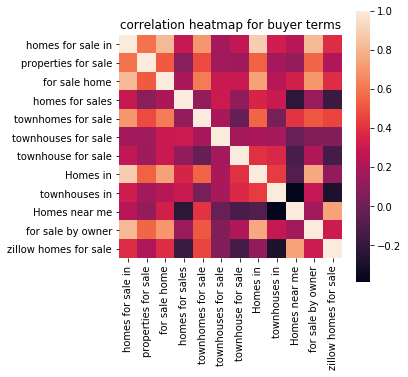

In [38]:
plt.figure(figsize=(5,5))
sns.heatmap(buyer_trend.iloc[:,2:].corr(),square=True)
plt.title('correlation heatmap for buyer terms')

Text(0.5, 1, 'correlation heatmap for seller terms')

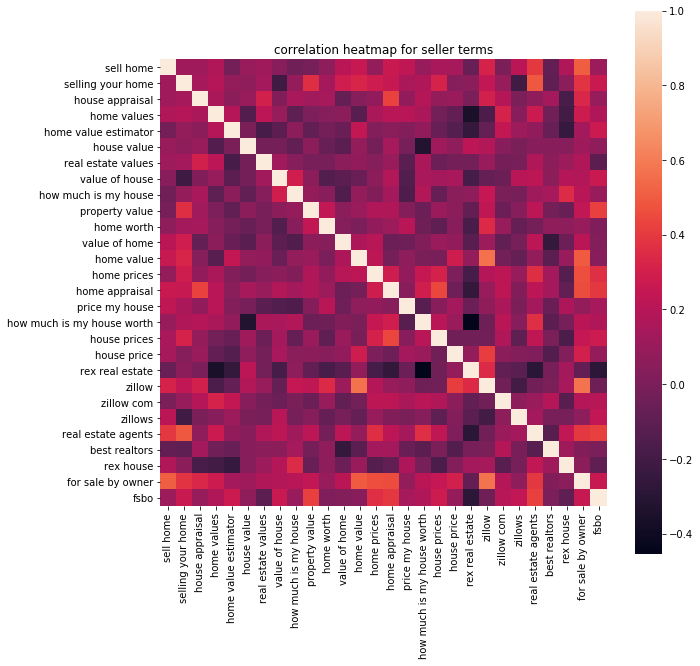

In [39]:
plt.figure(figsize=(10,10))
sns.heatmap(seller_trend.iloc[:,2:].corr(),square=True)
plt.title('correlation heatmap for seller terms')

From the correlation heatmap, it is worthwhile to notice that some keywords are very close to each other, like 'home for sale' and 'for sale home'. We could do some preprocessing before we build models.

### 2.2 particular search terms about buy/sell houses in a certain area

Ispired from the general used search terms, it is also promising to study some terms related to a particular area, such as "sell house in Denver". We then generate a list of keywords with the particular area.

In [40]:
denver_keywords= ['homes for sale in Denver',  'Homes in Denver', 'townhouses in Denver',
                'selling a house in Denver','sell home in Denver', 'selling your home in Denver',                 
                'house appraisal in Denver', 'home values in Denver', 'house price in Denver'                 
                 'for sale by owner in Denver','houses in Denver'                 
                 ]

In [46]:
denver_keyword_to_time_series = get_keyword_to_time_series(denver_keywords,geo='US')

homes for sale in Denver
Homes in Denver
townhouses in Denver
selling a house in Denver
sell home in Denver
selling your home in Denver
house appraisal in Denver
home values in Denver
house price in Denverfor sale by owner in Denver
houses in Denver


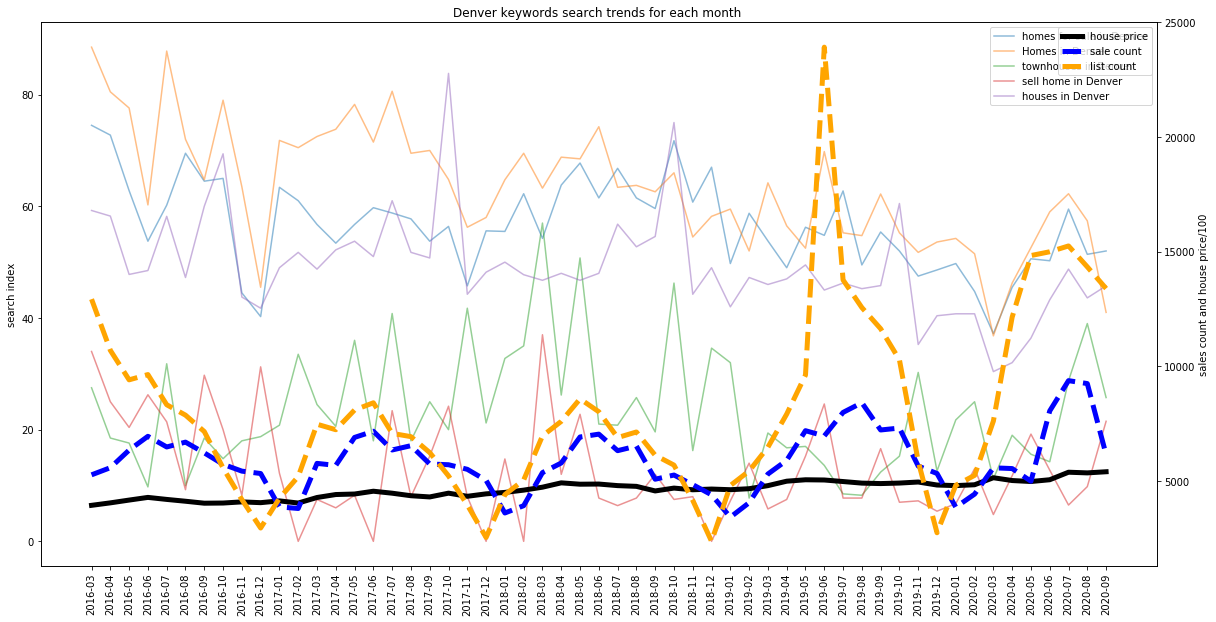

In [203]:
fig, ax1 = plt.subplots(figsize=(20,10))
for keyword, time_series in denver_keyword_to_time_series.items():
    time_series = pd.Series(time_series, index=monthData.month.values)
    ax1.plot(time_series, label=keyword,alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(monthData['month'],monthData['mean_price']/100,label='house price', color='black', linewidth=5)
ax2.plot(monthData['month'],monthData['count_sale'],'--',label='sale count',color='blue', linewidth=5)
ax2.plot(monthData['month'],monthData['count_list'],'--',label='list count',color='orange', linewidth=5)
ax2.set_ylabel('sales count and house price/100')
ax1.set_ylabel('search index')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.legend()
plt.title('Denver keywords search trends for each month ')
ax2.legend()
plt.show()


In [48]:
denver_trend = pd.DataFrame(denver_keyword_to_time_series, index=monthData.month.values).reset_index()
denver_trend.to_csv('denver_search_trend.csv')

Text(0.5, 1, 'correlation heatmap for denver terms')

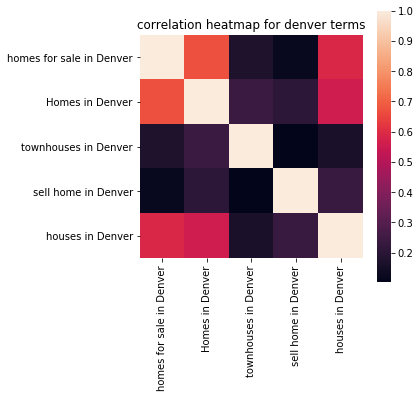

In [49]:
plt.figure(figsize=(5,5))
sns.heatmap(denver_trend.corr(),square=True)
plt.title('correlation heatmap for denver terms')

Terms related Denver is a relatively unpopular search, thus only a few keywords have records in google trends.

##  3. Merge google trends with monthly sells and price

In [50]:
#read google trends data
buyer_trend = pd.read_csv('buyer_search_trend.csv')
seller_trend = pd.read_csv('seller_search_trend.csv')
denver_trend = pd.read_csv('denver_search_trend.csv')

In [85]:
merged = pd.merge(pd.merge(monthData, seller_trend, left_on ='month', right_on='index').drop(['Unnamed: 0','index'],axis=1),buyer_trend,
         left_on='month',right_on='index')
merged = merged.drop(['index','Unnamed: 0', 'for sale by owner_y'], axis=1)
merged = pd.merge(merged, denver_trend, left_on ='month', right_on='index').drop(['Unnamed: 0','index'],axis=1)

In [86]:
merged.head()

,month,count_sale,mean_price,count_list,selling a house,sell home,selling your home,house appraisal,home values,home value estimator,...,townhouse for sale,Homes in,townhouses in,Homes near me,zillow homes for sale,homes for sale in Denver,Homes in Denver,townhouses in Denver,sell home in Denver,houses in Denver
0,2016-03,5259,392825.600494,12926,70.75,64.50,26.50,29.25,37.75,27.50,...,46.50,91.25,45.75,14.00,21.50,74.50,88.50,27.50,34.00,59.25
1,2016-04,5571,403625.623586,10692,56.00,55.75,23.25,29.00,25.25,28.25,...,34.50,93.50,22.50,15.25,32.75,72.75,80.50,18.50,25.00,58.25
2,2016-05,6340,415779.824132,9405,46.00,49.60,20.00,17.20,16.40,43.40,...,24.00,88.00,37.00,13.40,27.60,62.80,77.60,17.60,20.40,47.80
3,2016-06,6941,427446.501945,9635,46.75,47.25,41.50,36.00,47.25,37.50,...,34.75,82.00,38.25,18.50,35.50,53.75,60.25,9.75,26.25,48.50
4,2016-07,6476,418647.276714,8318,49.00,49.80,20.40,29.80,38.80,24.60,...,28.80,83.60,32.00,17.20,39.80,60.20,87.80,31.80,21.40,58.20


In [204]:
merged['count_sale_lead1'] = merged['count_sale'].shift(-3)
merged['mean_price_lead1'] = merged['mean_price'].shift(-3)
merged['count_list_lead1'] = merged['count_list'].shift(-3)

In [206]:
merged.tail()

,month,count_sale,mean_price,count_list,selling a house,sell home,selling your home,house appraisal,home values,home value estimator,...,Homes near me,zillow homes for sale,homes for sale in Denver,Homes in Denver,townhouses in Denver,sell home in Denver,houses in Denver,count_sale_lead1,mean_price_lead1,count_list_lead1
49,2020-04,5533,501061.759283,12141,35.00,38.00,16.00,14.25,21.25,19.0,...,55.00,23.00,45.50,46.25,19.00,11.75,32.00,9370.0,537337.274979,15248.0
50,2020-05,4981,496792.988540,14829,40.00,55.80,21.80,23.80,26.60,16.0,...,74.80,60.00,50.60,52.60,15.60,19.20,36.40,9242.0,534460.182143,14335.0
51,2020-06,8048,504526.000870,14994,49.25,58.50,30.75,12.25,27.75,51.5,...,82.50,59.50,50.25,59.00,14.25,12.75,43.25,NaN,NaN,NaN
52,2020-07,9370,537337.274979,15248,50.25,61.75,17.25,40.00,30.75,10.5,...,82.75,78.25,59.50,62.25,28.75,6.50,48.75,NaN,NaN,NaN
53,2020-08,9242,534460.182143,14335,43.40,56.60,17.80,28.40,27.20,27.6,...,66.40,79.80,51.40,57.40,39.00,9.80,43.60,NaN,NaN,NaN


### 3.1 lead count_sale, mean_price, count_list's correlation with features

In [207]:
target_column_names = ['count_sale_lead1', 'mean_price_lead1','count_list_lead1']
feature_column_names = merged.columns[1:-3]
corr = []
for j in target_column_names:
    corr_1 = []
    for i in feature_column_names:
        corr_1.append(np.corrcoef(merged[j][:-3], merged[i][:-3])[0][1])
    corr.append(corr_1)
corr = np.array(corr)

Text(0.5, 1.0, 'correlation between count_sale_lead1 and features')

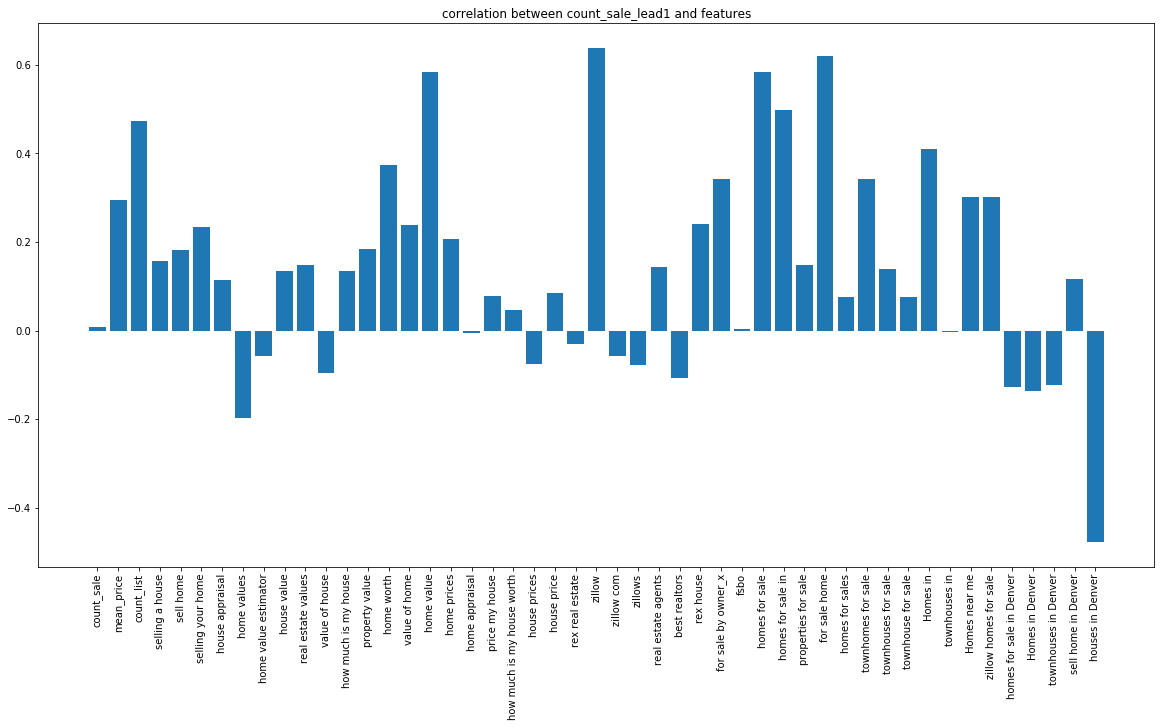

In [208]:
plt.figure(figsize=(20, 10))
plt.bar(height=corr[0],x=feature_column_names)
plt.xticks(rotation=90)
plt.title('correlation between count_sale_lead1 and features')

From the correlation, we can see that many terms have a strong correlation with the sales number three months later. Thus, we expect that google trends can predict the monthly sale house number quite well. 

Text(0.5, 1.0, 'correlation between mean_price_lead1 and features')

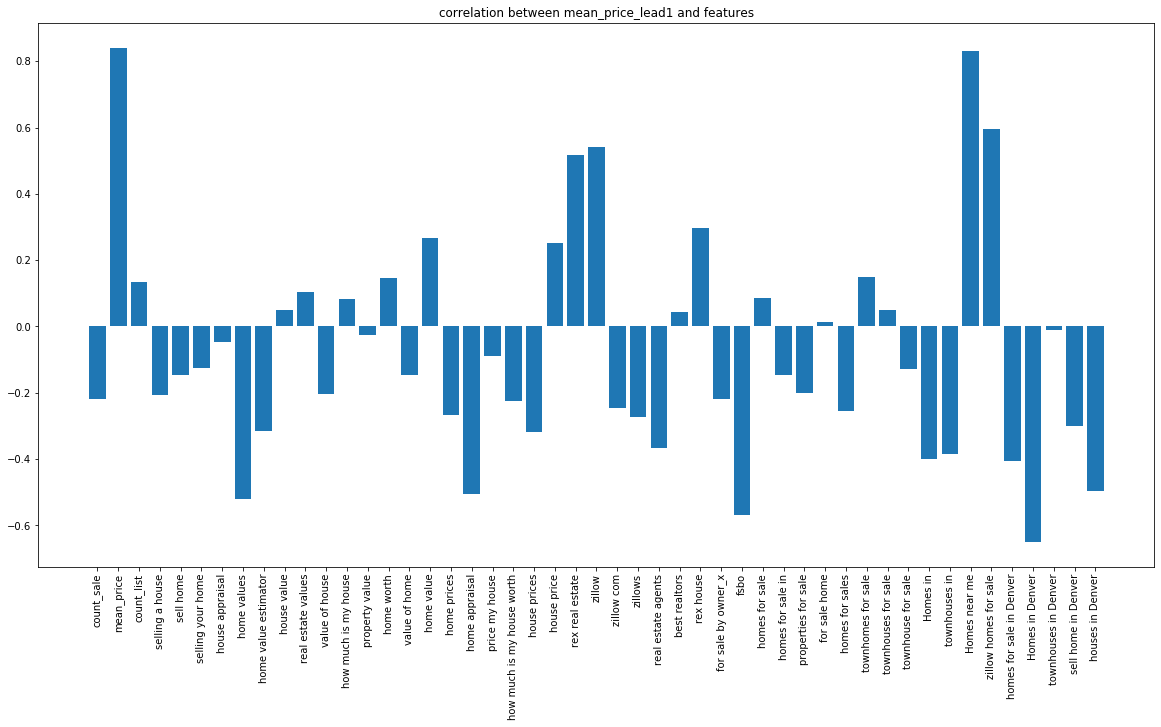

In [209]:
plt.figure(figsize=(20, 10))
plt.bar(height=corr[1],x=feature_column_names)
plt.xticks(rotation=90)
plt.title('correlation between mean_price_lead1 and features')

From the correlation plot, we can see that 'mean_price' has the mose positive correlation with mean price lead1, which means that the price data is autocorrelated. 'homes near me' and 'zillow homes for sale' also have strong correlations with the mean price. 

Text(0.5, 1.0, 'correlation between count_list_lead1 and features')

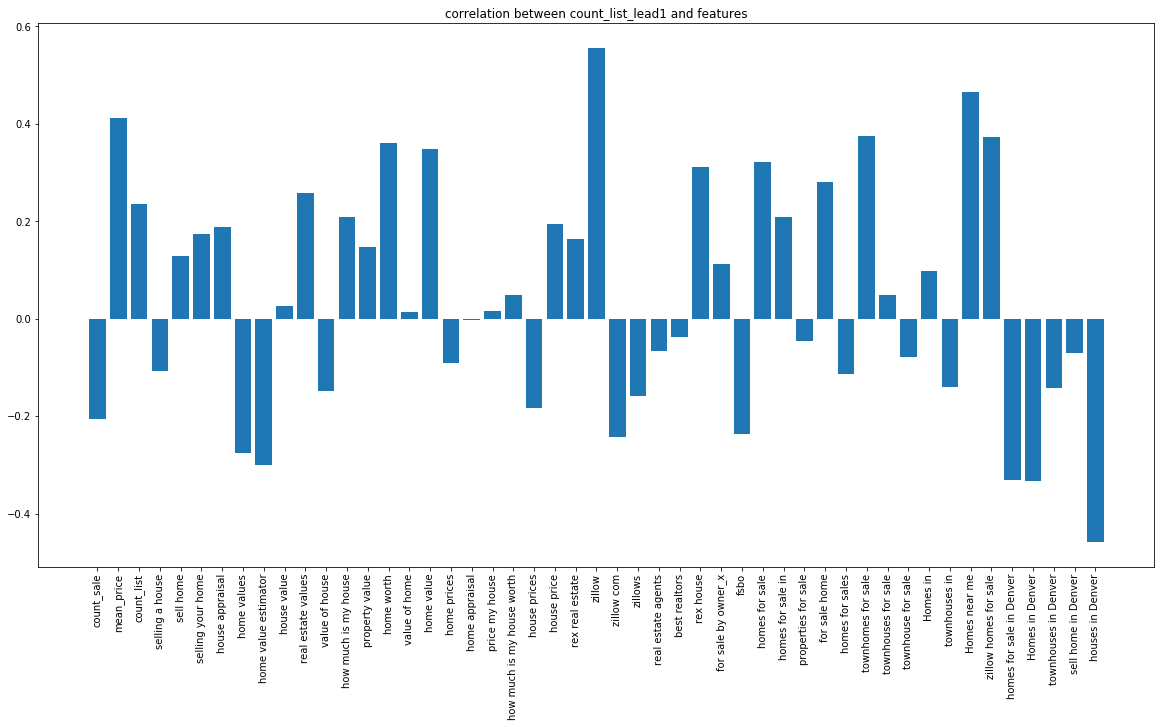

In [210]:
plt.figure(figsize=(20, 10))
plt.bar(height=corr[2],x=feature_column_names)
plt.xticks(rotation=90)
plt.title('correlation between count_list_lead1 and features')

Apart from the autocorrelated term, 'zillow' is a term that have strong correlation with listing data. This is a seller term that has the largest ads impression from our data set.

### 3.2 Baseline model with google trends: linear regression (Lasso)

In [243]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [211]:
#Since some features are strongly correlated, use Lasso regression to select features

#split the data first
merged = merged.dropna(axis=0)
train_X, test_X, train_y, test_y = train_test_split(merged[feature_column_names],merged[target_column_names], test_size = 0.2, shuffle=False)
#standardize the features
std = StandardScaler()
std.fit(train_X)
train_X_std =std.transform(train_X)
test_X_std = std.transform(test_X)


### 3.2.1 predict the sales number

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12229.063580077054, tolerance: 4629.429986666666
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10050.614884525383, tolerance: 4784.451386666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8820.763187623088, tolerance: 4820.884386666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

Text(0, 0.5, 'score')

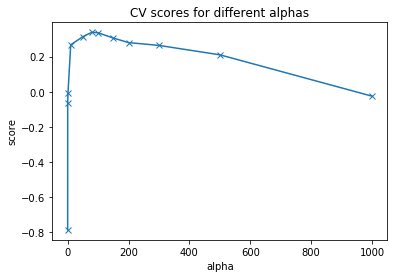

In [212]:
#linear regression(lasso)
#using cross validation to choose alpha in Lasso
alphas = [1e-2, 1e-1, 1., 10,50, 80, 100, 150, 200,300,500,1e3]
scores_cv = []
for a in alphas:
    lr = Lasso(alpha=a)
    scores_cv.append(cross_val_score(lr, train_X_std, train_y['count_sale_lead1'], cv=4).mean())
plt.plot(alphas,scores_cv,'x-')
plt.title('CV scores for different alphas')
plt.xlabel('alpha')
plt.ylabel('score')

In [213]:
#alpha =100
lr = Lasso(alpha=100)
lr.fit(train_X_std, train_y['count_sale_lead1'])
train_y_pred = lr.predict(train_X_std)
test_y_pred = lr.predict(test_X_std)
print('training score for predicting sales count lead 1: ', lr.score(train_X_std, train_y['count_sale_lead1']))
print('test score for predicting sales count lead 1: ', lr.score(test_X_std, test_y['count_sale_lead1']))
print('training MSE for predicting sales count lead 1: ', mean_squared_error(train_y['count_sale_lead1'], train_y_pred))
print('test MSE for predicting sales count lead 1: ', mean_squared_error(test_y['count_sale_lead1'], test_y_pred))
print(lr.coef_[lr.coef_!=0])
selected_features = feature_column_names[lr.coef_!=0]

print(feature_column_names[lr.coef_!=0])

training score for predicting sales count lead 1:  0.8325148747280864
test score for predicting sales count lead 1:  0.3266983438095237
training MSE for predicting sales count lead 1:  239993.17092041852
test MSE for predicting sales count lead 1:  2201019.07427673
[ -39.93170648   55.20080121  -80.51096703  105.36239225   47.60066523
   93.1624238   -98.06658536  -51.92741183  447.57030003  -74.18599746
   71.09622183  -26.66767719   71.51934275  303.70151277 -359.52460511]
Index(['count_sale', 'sell home', 'home values', 'how much is my house',
       'value of home', 'home value', 'home prices', 'house prices', 'zillow',
       'zillow com', 'real estate agents', 'best realtors',
       'homes for sale in', 'Homes in', 'houses in Denver'],
      dtype='object')


In [246]:
lr = LassoCV(cv=4)
lr.fit(train_X_std, train_y['count_sale_lead1'])
train_y_pred = lr.predict(train_X_std)
test_y_pred = lr.predict(test_X_std)
print('training score for predicting sales count lead 1: ', lr.score(train_X_std, train_y['count_sale_lead1']))
print('test score for predicting sales count lead 1: ', lr.score(test_X_std, test_y['count_sale_lead1']))
print('training MSE for predicting sales count lead 1: ', mean_squared_error(train_y['count_sale_lead1'], train_y_pred))
print('test MSE for predicting sales count lead 1: ', mean_squared_error(test_y['count_sale_lead1'], test_y_pred))
print(lr.coef_[lr.coef_!=0])
selected_features = feature_column_names[lr.coef_!=0]

print(feature_column_names[lr.coef_!=0])

training score for predicting sales count lead 1:  0.9831066351850007
test score for predicting sales count lead 1:  0.20638921266176746
training MSE for predicting sales count lead 1:  24206.879165447746
test MSE for predicting sales count lead 1:  2594308.9021439585
[-137.40823644   87.24142839  129.97165822  104.09330414 -181.59220244
 -292.8265095     4.33405146  284.00229799   84.42196134   40.33176918
   60.65069781 -256.00547585 -232.76021959  -16.48828794 -200.93087388
 -112.74082254  519.01274928  -29.19127334 -131.67395314   44.68393054
   34.95350688   -7.50326572 -184.48881103  147.13984701   41.41925767
  610.07608447  -26.64858432   29.03755072  -37.69374529  -24.34049268
  -21.45947782 -360.38345136]
Index(['count_sale', 'selling a house', 'sell home', 'house appraisal',
       'home values', 'home value estimator', 'value of house',
       'how much is my house', 'home worth', 'value of home', 'home value',
       'home prices', 'home appraisal', 'how much is my house w

In [200]:
#train_X_std_con = sm.add_constant(train_X_std[:,lr.coef_!=0])
#test_X_std_con = sm.add_constant(test_X_std[:,lr.coef_!=0])
#results = sm.OLS(train_y['count_sale_lead1'], train_X_std_con).fit()
#print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       count_sale_lead1   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     27.71
Date:                Sun, 04 Oct 2020   Prob (F-statistic):           5.61e-13
Time:                        20:57:19   Log-Likelihood:                -316.39
No. Observations:                  43   AIC:                             654.8
Df Residuals:                      32   BIC:                             674.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5844.0000     67.096     87.100      0.0

Text(0.5, 1.0, 'model prediction for house sales number 3 month later')

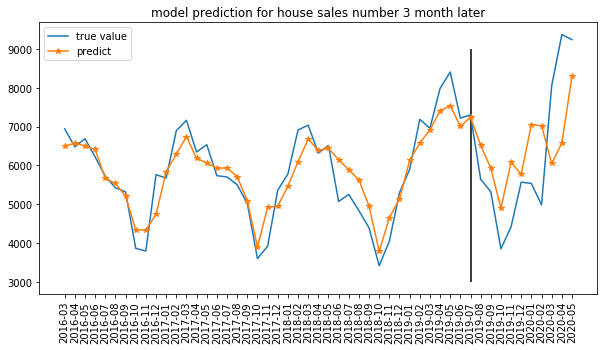

In [214]:
plt.figure(figsize=(10,5))
plt.plot(merged.month, merged['count_sale_lead1'],label='true value')
plt.plot(np.append(train_y_pred,test_y_pred),'-*',label='predict')
plt.legend()
plt.xticks(rotation=90)
plt.vlines(x=merged.month[len(train_y_pred)],ymin=3000,ymax=9000)
plt.title('model prediction for house sales number 3 month later')

### 3.2.2 predict the mean price

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1978270.0343039525, tolerance: 1437915.6726383697
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4460988.240919017, tolerance: 1437915.6726383697
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4870152.454323519, tolerance: 3568803.790407454
  positive)


Text(0, 0.5, 'score')

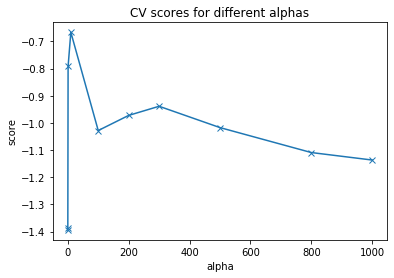

In [215]:
alphas = [1e-2, 1e-1, 1., 10,100,200,300,500, 800,1e3]
scores_cv = []
for a in alphas:
    lr = Lasso(alpha=a)
    scores_cv.append(cross_val_score(lr, train_X_std, train_y['mean_price_lead1'], cv=4).mean())

plt.plot(alphas,scores_cv,'x-')
plt.title('CV scores for different alphas')
plt.xlabel('alpha')
plt.ylabel('score')

In [218]:
#alpha=2000
lr = Lasso(alpha=2000)
lr.fit(train_X_std, train_y['mean_price_lead1'])
train_y_pred = lr.predict(train_X_std)
test_y_pred = lr.predict(test_X_std)
print('training score for predicting mean_price_lead1: ', lr.score(train_X_std, train_y['mean_price_lead1']))
print('test score for predicting mean_price_lead1: ', lr.score(test_X_std, test_y['mean_price_lead1']))
print('training MSE for predicting mean_price_lead1: ', mean_squared_error(train_y['mean_price_lead1'], train_y_pred))
print('test MSE for predicting mean_price_lead1: ', mean_squared_error(test_y['mean_price_lead1'], test_y_pred))
print(lr.coef_[lr.coef_!=0])
print(feature_column_names[lr.coef_!=0])

training score for predicting mean_price_lead1:  0.9355940494661558
test score for predicting mean_price_lead1:  0.21778315592659714
training MSE for predicting mean_price_lead1:  61016877.260606706
test MSE for predicting mean_price_lead1:  283527942.8731393
[-10506.75907076  15605.96782007     88.43679878  -1987.38015772
   -100.3545961   -1106.8446       1119.17325701  -1175.51865792
    454.25620747   9057.17106298    825.52452987]
Index(['count_sale', 'mean_price', 'sell home', 'home values',
       'home appraisal', 'house prices', 'rex house', 'fsbo',
       'townhouse for sale', 'Homes near me', 'townhouses in Denver'],
      dtype='object')


In [245]:
lr = LassoCV(cv=4)
lr.fit(train_X_std, train_y['mean_price_lead1'])
train_y_pred = lr.predict(train_X_std)
test_y_pred = lr.predict(test_X_std)
print('training score for predicting mean_price_lead1: ', lr.score(train_X_std, train_y['mean_price_lead1']))
print('test score for predicting mean_price_lead1: ', lr.score(test_X_std, test_y['mean_price_lead1']))
print('training MSE for predicting mean_price_lead1: ', mean_squared_error(train_y['mean_price_lead1'], train_y_pred))
print('test MSE for predicting mean_price_lead1: ', mean_squared_error(test_y['mean_price_lead1'], test_y_pred))
print(lr.coef_[lr.coef_!=0])
print(feature_column_names[lr.coef_!=0])

training score for predicting mean_price_lead1:  0.9935042545326556
test score for predicting mean_price_lead1:  -0.7605567108944744
training MSE for predicting mean_price_lead1:  6153936.097703031
test MSE for predicting mean_price_lead1:  638144047.0547692
[-14063.82041878  20006.3482651    1355.78022878   5360.18337863
  -1203.27500652    497.34856312  -1962.60424753   2144.32106638
   1550.57177759  -1648.93743316    126.65567537  -3440.21614861
  -3117.17065772    570.01326124    105.38407129   1375.95711843
   -230.14851569   -559.57663712    953.66246936   1195.04978472
   4771.5210128    1066.6965989    -632.80021329  -2971.98842436
    602.66151704]
Index(['count_sale', 'mean_price', 'selling a house', 'sell home',
       'home values', 'real estate values', 'value of house',
       'how much is my house', 'property value', 'home worth', 'value of home',
       'price my house', 'house prices', 'house price', 'real estate agents',
       'rex house', 'for sale by owner_x', 'fs

Text(0.5, 1.0, 'model prediction for mean trade price 3 month later')

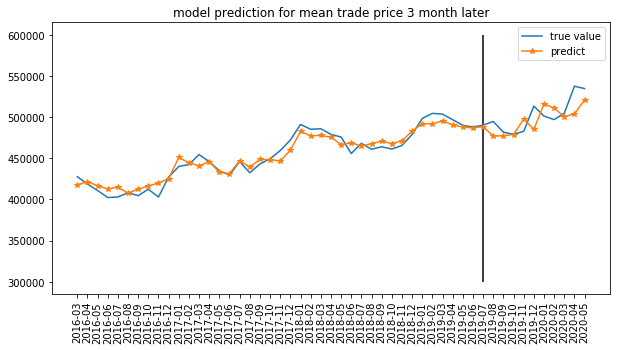

In [219]:
plt.figure(figsize=(10,5))
plt.plot(merged.month, merged['mean_price_lead1'],label='true value')
plt.plot(np.append(train_y_pred,test_y_pred),'-*',label='predict')
plt.legend()
plt.xticks(rotation=90)
plt.vlines(x=merged.month[len(train_y_pred)],ymin=300000,ymax=600000)
plt.title('model prediction for mean trade price 3 month later')

### 3.2.3 predict the newly listed house number

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78105.4924218591, tolerance: 47584.529070000004
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63144.85051745303, tolerance: 47720.39309666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85454.9526152547, tolerance: 50762.42198666666
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase 

Text(0, 0.5, 'score')

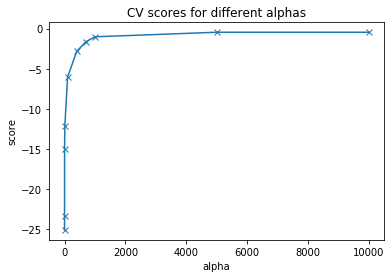

In [234]:
alphas = [1e-2, 1e-1, 1.,10,100,400,700,1e3,5e3, 1e4]
scores_cv = []
for a in alphas:
    lr = Lasso(alpha=a)
    scores_cv.append(cross_val_score(lr, train_X_std, train_y['count_list_lead1'], cv=4).mean())
plt.plot(alphas,scores_cv,'x-')
plt.title('CV scores for different alphas')
plt.xlabel('alpha')
plt.ylabel('score')

In [233]:

lr = Lasso(alpha=400)
lr.fit(train_X_std, train_y['count_list_lead1'])
train_y_pred= lr.predict(train_X_std)
test_y_pred = lr.predict(test_X_std)
print('training score for predicting count_list_lead1: ', lr.score(train_X_std, train_y['count_list_lead1']))
print('test score for predicting count_list_lead1: ', lr.score(test_X_std, test_y['count_list_lead1']))
print('training MSE for predicting count_list_lead1: ', mean_squared_error(train_y['count_list_lead1'], train_y_pred))
print('test MSE for predicting count_list_lead1: ', mean_squared_error(test_y['count_list_lead1'], test_y_pred))
print(lr.coef_[lr.coef_!=0])
print(feature_column_names[lr.coef_!=0])

training score for predicting count_list_lead1:  0.5370517822950045
test score for predicting count_list_lead1:  0.2537051619980222
training MSE for predicting count_list_lead1:  6120355.846376395
test MSE for predicting count_list_lead1:  15225422.365967976
[-120.83421343 -437.11967399  197.49611415  187.49401476 -673.13900752
  196.89885326 -101.38102814 1593.81052726 -249.36148926   20.75595521
   30.79300253 -398.96885158]
Index(['count_sale', 'home value estimator', 'how much is my house',
       'home value', 'home prices', 'how much is my house worth',
       'house prices', 'zillow', 'zillow com', 'rex house',
       'townhomes for sale', 'houses in Denver'],
      dtype='object')


Text(0.5, 1.0, 'model prediction for listing number 1 month later')

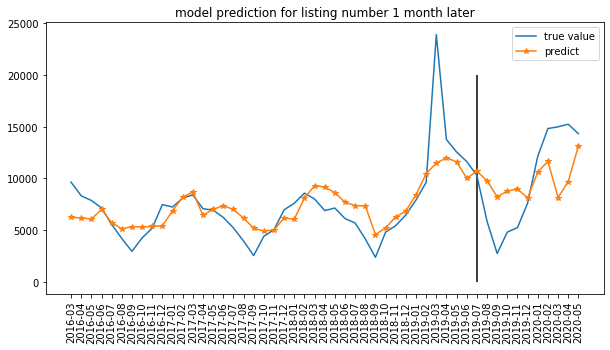

In [235]:
plt.figure(figsize=(10,5))
plt.plot(merged.month, merged['count_list_lead1'],label='true value')
plt.plot(np.append(train_y_pred,test_y_pred),'-*',label='predict')
plt.legend()
plt.xticks(rotation=90)
plt.vlines(x=merged.month[len(train_y_pred)],ymin=0,ymax=20000)
plt.title('model prediction for listing number 1 month later')

## 4. Future works 

We can find that using google trends to predict house sales, price, and listing data is very promising from EDA and Lasso regression baseline model. The results lead to many possible discussions in the future.
1. Time series: Google trend is one kind of time series data, but time series property has not been used here.
2. Model improvement: More feature engineering, dimension reduction, and build more models(both linear and nonlinear).
3. Other features: Include other predictive features except for google trends, such as real-time bidding data, census data, etc.
4. Time intervals: From monthly data to weekly or even daily data, or change the prediction horizon.
5. Space: Narrow down the Denver area to a specific zipcode in Denver(maybe hard by google trends API restriction), or try models in other cities.
 
